In [27]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from numpy import genfromtxt
import quantities as pq

In [28]:
def get_rows(file):
    my_data = genfromtxt(file,delimiter=',',skip_header=1)

    times,cells = np.array(zip(*my_data))
    times = times * pq.ms
    
    rows = []
    for cell in set(cells):
       rows.append(times[np.where(cells == cell)]) 
    return rows

mc_rows = get_rows(file = 'Urban Burton 2014 6A mc-points.csv')
tc_rows = get_rows(file = 'Urban Burton 2014 6B tc-points.csv')

('MC IFR change First-Last Hz', (-9.432831837722242, 17.832782181869668, 35))
('TC IFR change First-Last Hz', (-20.20968657857211, 19.09576221239726, 28))


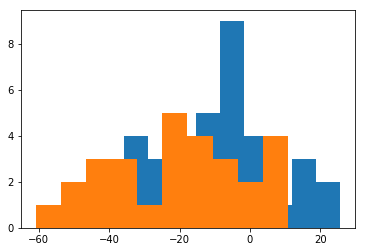

In [40]:
def get_IFR_changes(rows):
    ifr_changes = []

    for times in rows:
        #times = mc_rows[-0]
        isis = np.diff(times)
        ifrs = 1.0/isis
        ifrs.units = pq.Hz
        ifr_times = times[1:]
        ifr_change = ifrs[-1] - ifrs[0]

    #     plt.plot(ifr_times, ifrs)
    #     print(ifrs)
    #     print(ifr_change)

        ifr_changes.append(ifr_change)

    plt.hist(ifr_changes)
    return (np.mean(ifr_changes), np.std(ifr_changes), len(ifr_changes))
    
print('MC IFR change First-Last Hz', get_IFR_changes(mc_rows))
print('TC IFR change First-Last Hz', get_IFR_changes(tc_rows))


('MC IFR Time constants', (398.58430799332217, 562.0434206729059, 35))
('TC IFR Time constants', (585.6785638611162, 664.713044151611, 28))


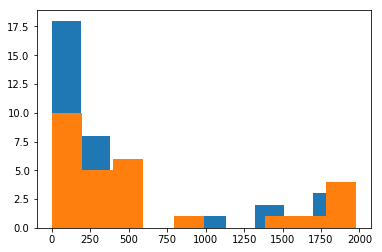

In [68]:
def get_IFR_taus(rows):
    taus = []
    for times in rows:
        isis = np.diff(times)
        ifrs = 1.0/isis
        ifrs.units = pq.Hz
        ifrs = ifrs.magnitude

        ifr_times = times[1:]
        ifr_times = ifr_times - ifr_times[0]
        ifr_times = ifr_times.magnitude

        def ifr_func(t, start, finish, tau):
            return (start - finish) *np.exp(-t / tau) + finish

        from lmfit import Model

        model = Model(ifr_func)
        params = model.make_params(start=ifrs[0], finish=ifrs[-1], tau=10.0)

        params['tau'].min = 0
        params['tau'].max = np.max(ifr_times)
        result = model.fit(ifrs, t=ifr_times, params=params)

        start = result.best_values["start"]
        finish = result.best_values["finish"]
        tau = result.best_values["tau"]

        #plt.plot(ifr_times, ifrs, 'bo')
        #plt.plot(ifr_times, result.best_fit, 'r-')
        #plt.show()
        
        taus.append(tau)
    
    plt.hist(taus)
    return np.mean(taus), np.std(taus), len(taus)

print('MC IFR Time constants', get_IFR_taus(mc_rows))
print('TC IFR Time constants', get_IFR_taus(tc_rows))